# Projet d'analyse d'alimentation de pays différents

### Liens

- [Site Santé Publique France](https://www.santepubliquefrance.fr/)
- [Lien de téléchargement du fichier fr.openfoodfacts.org.products.csv](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip) à mettre dans la racine du projet
- [Description des attributs](https://world.openfoodfacts.org/data/data-fields.txt)

## Partie de nettoyage des données

Dans un premier et dans le but de faciliter la compréhension des données, l'objectif est d'analyser celles-ci quantitativement et qualitativement. 

La partie suivante inclue la mise en évidence des valeurs manquantes avec au moins 3 méthodes de traitement adatpées aux variables concernées et d'identification et quantification de valeurs abbérantes.

### Imports des modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer, KNNImputer

On lit le fichier `fr.openfoodfacts.org.products.csv` avec le séparateur `\t`. Les données seront dans la variable `data`

In [2]:
data = pd.read_csv("fr.openfoodfacts.org.products.csv", sep="\t")

/tmp/ipykernel_41310/1111784718.py:1: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("fr.openfoodfacts.org.products.csv", sep="\t")


In [3]:
data.describe()

,no_nutriments,additives_n,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,nutrition_grade_uk,energy_100g,energy-from-fat_100g,fat_100g,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
count,0.0,248939.000000,248939.000000,0.0,248939.000000,0.0,0.0,2.611130e+05,857.000000,243891.000000,...,49.000000,3036.000000,165.000000,948.000000,0.0,268.000000,221210.000000,221210.000000,0.0,0.0
mean,NaN,1.936024,0.019659,NaN,0.055246,NaN,NaN,1.141915e+03,585.501214,12.730379,...,6.425698,31.458587,15.412121,49.547785,NaN,341.700764,9.165535,9.058049,NaN,NaN
std,NaN,2.502019,0.140524,NaN,0.269207,NaN,NaN,6.447154e+03,712.809943,17.578747,...,2.047841,31.967918,3.753028,18.757932,NaN,425.211439,9.055903,9.183589,NaN,NaN
min,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,8.000000,6.000000,NaN,0.000000,-15.000000,-15.000000,NaN,NaN
25%,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,3.770000e+02,49.400000,0.000000,...,6.300000,0.000000,12.000000,32.000000,NaN,98.750000,1.000000,1.000000,NaN,NaN
50%,NaN,1.000000,0.000000,NaN,0.000000,NaN,NaN,1.100000e+03,300.000000,5.000000,...,7.200000,23.000000,15.000000,50.000000,NaN,195.750000,10.000000,9.000000,NaN,NaN
75%,NaN,3.000000,0.000000,NaN,0.000000,NaN,NaN,1.674000e+03,898.000000,20.000000,...,7.400000,51.000000,15.000000,64.250000,NaN,383.200000,16.000000,16.000000,NaN,NaN
max,NaN,31.000000,2.000000,NaN,6.000000,NaN,NaN,3.251373e+06,3830.000000,714.290000,...,8.400000,100.000000,25.000000,100.000000,NaN,2842.000000,40.000000,40.000000,NaN,NaN


In [4]:
# On peut d'ores et déjà formatter les valeurs NaN
data.replace(['None', 'nan', None, 'NaN', ' '], np.nan, inplace=True)

### Analyse quantitative des données

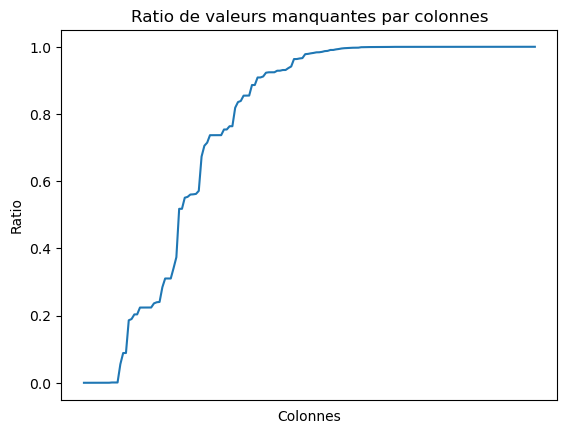

Sur tout le dataset, on a un taux de valeurs manquantes qui équivaut à 76.22 %.
Sur 162 colonnes, il y en a 16 qui n'ont aucune valeurs
Les colonnes qui n'ont aucune valeurs sont les suivantes :
['no_nutriments' 'ingredients_from_palm_oil'
 'ingredients_that_may_be_from_palm_oil' 'nutrition_grade_uk'
 'butyric-acid_100g' 'caproic-acid_100g' 'lignoceric-acid_100g'
 'cerotic-acid_100g' 'melissic-acid_100g' 'elaidic-acid_100g'
 'mead-acid_100g' 'erucic-acid_100g' 'nervonic-acid_100g'
 'chlorophyl_100g' 'glycemic-index_100g' 'water-hardness_100g']


In [5]:
# On peut définir une fonction qui nous permettra plus tard d'identifier le pourcentage de Nulls pour une colonne
def defined_percentage(data, col):
    c = data.loc[data[col].notna(), col]
    return (len(c) / data.shape[0]) * 100, c

# On lis les valeurs non definies
missing = data.isna()
# On les compte et on créer un nouveau DataFrame
missing_sum = pd.DataFrame(missing.sum(), columns=['nb_manquants'])
# On calcul et ajoute le ratio du nombre de valeurs non définies au DataFrame
missing_sum["ratio"] = ((missing_sum["nb_manquants"] / len(data)) )

# On va construire un graphique pour nous montrer le nombre de valeurs manquantes
plt.title("Ratio de valeurs manquantes par colonnes")
plt.ylabel("Ratio")
plt.xlabel("Colonnes")
plt.xticks([])
plt.plot(missing_sum.sort_values(["ratio"])["ratio"])
plt.show()
# On garde les ratio == 1
missing_sum_1 = missing_sum[missing_sum["ratio"] == 1]

ratio_missing = missing_sum["nb_manquants"].sum() / data.size

print(f"Sur tout le dataset, on a un taux de valeurs manquantes qui équivaut à {(ratio_missing*100):.2f} %.")
print(f"Sur {len(missing_sum)} colonnes, il y en a {len(missing_sum_1)} qui n'ont aucune valeurs")
print(f"Les colonnes qui n'ont aucune valeurs sont les suivantes :")
print(missing_sum_1.index.to_numpy())

La conclusion de cette analyse est qu'actuellement nous disposons de 25 % de données exploitables. On aura certainement une valeur différente après le traitement des valeurs manquantes.

## Conservation des données utiles au projet uniquement

In [6]:

data = data.filter([
    "url",
    "product_name",
    "generic_name",
    "quantity",
    "countries_tags",
    "image_url",
    "image_small_url",
    "nutrition-score-fr_100g",
    "additives_n",
    "fat_100g",
    "saturated-fat_100g",
    "energy_100g",
    "sugars_100g"
], axis=1)

missing_ratio = pd.DataFrame(data.isna().sum(), columns=['nb_manquants']).sum() / data.size

print(f"Après conservation des données utiles au projet, il n'y a plus que {(missing_ratio[0]*100):.2f} % de valeurs manquantes.")

Après conservation des données utiles au projet, il n'y a plus que 35.18 % de valeurs manquantes.


# Traitement des erreurs sur les variables générales

### Les champs `product_name` et `generic_name`

On pourra utiliser principalement le `product_name` pour récupérer le nom du produit et en cas d'erreur essayer d'utiliser le `generic_name`.
Ainsi on peut donc d'abord corriger les données de `generic_name` pour être sûr que la valeur qui sera possiblement remplacée dans `generic_name` sera valide. Ensuite on pourra corriger les autres données de `product_name` qui n'ont pas été remplacée mais qui malgré tout ne sont pas acceptables.

Si malgré tout il y a des valeurs qui ne sont pas définies, on gardera ces lignes car ce qui compte c'est d'effectuer des comparaisons avec d'autres données. De plus, si on ne conservait pas ces lignes, comme on peut le voir dans le script, il ne nous resterait que peu de données à exploiter.

Les traitements à effectuer sur `generic_name` sont les suivants :
- Ne pas prendre en compte les nulls
- Il y a des champs avec uniquement un espace à l'intérieur. On ne peut corriger ces lignes
- Ne pas prendre en compte les noms trop long car sinon ce n'est plus un nom mais une description. On ne peut pas corriger ces lignes. Même en séparant par une virgule cela ne fonctionne pas car dans la plupart des cas on obtient plusieurs fois le même nom.

Les traitements à effectuer sur `product_name` sont les suivants:
- Ne pas prendre en compte les nulls
- Remplacer les valeurs non valide par sa valeur `generic_name`, `generic_name` étant valide

In [7]:
# On split sur la virgule et récupère le dernier élément qui semble être le plus représentatif d'un vrai nom.
data.loc["product_name"] = data["product_name"].str.split(",").str[-1]

# -------------
# generic_name

# On conserve les non null
generic_exists = data["generic_name"].notna()
# On conserve les lignes qui ne contiennent pas uniquement des espaces
generic_no_space = data["generic_name"].ne(" ")
# On conserve les noms en dessous de 50 caractères
generic_not_long = data["generic_name"].fillna("").str.len() < 50
# Test booléen
generic = generic_exists & generic_no_space & generic_not_long
# Table qui contient les éléments qui respectent les critères précédents
generic_match = data.loc[generic, ["generic_name"]]
print(f"Il y a {generic_match.size} generic_names sur {data.shape[0]} qui sont considérés comme valide, soit {((generic_match.size/data.shape[0])*100):.2f} %")

# -------------
# product_name

# Retirer les nulls
product_exists = data["product_name"].notna()
# Table qui contient les éléments qui respectent les critères précédents
product_match = data.loc[product_exists, ["product_name"]]

# Colonnes qui ne contiennent pas de product_name mais contiennent un generic_name
no_product_with_generic = (~product_exists) & generic
print(f"Il y a {no_product_with_generic.value_counts()[True]} lignes pour lesquelles il existe un generic_name valide mais pas de product_name valide")

# Remplacer les product_name non valide par son generic_name valide dans data
data.loc[no_product_with_generic, ["product_name"]] = data.loc[no_product_with_generic, ["generic_name"]]

# On peut désormait retirer generic_name qui n'est plus d'aucune utilité
data.drop(["generic_name"], axis=1, inplace=True)

Il y a 38739 generic_names sur 320773 qui sont considérés comme valide, soit 12.08 %
Il y a 83 lignes pour lesquelles il existe un generic_name valide mais pas de product_name valide


### La colonne `countries_tags`

Pour le projet il est important de recenser les pays qui sont mentionnés dans nos données. Dans les données proposée, il y avais également le champ `countries` mais j'ai remarqué qu'il y avait quelques erreurs dedans. Je préfère créer un dictionnaire qui va me permettre de convertir les tags en nom pour pouvoir les utiliser plus tard. C'est ce qui me permet de corriger de la façon la plus simple les erreurs de lexicales.

Certains tags ne veulent rien dire, par exemple avec la valeur `Catégories complétées`. On peut donc éliminer ce type de lignes.

Il y a également un mixe entre les pays avec des valeurs en `en:...` et `fr:...`. Ce sont différentes façon d'écrire un même pays.

In [8]:
import utils.countriesMap as cm
import re

countries_tags_count = data["countries_tags"].value_counts()

# On récupère toutes les valeurs possibles de tags et on en garde 1 seul exemplaire
all_countries = pd.DataFrame(countries_tags_count.index.str.split(',')).explode(0).drop_duplicates()
# Il y a des pays qui ne contiennent pas le string ":". Ce ne sont donc pas des pays
all_countries = all_countries.loc[all_countries[0].str.contains(":")]
# On retire les préfixes
all_countries[0].replace('^.*:','', regex=True, inplace=True)
# Cela peut entrainé des doublons, par exemple fr:france et en:france => france et france
all_countries.drop_duplicates(inplace=True)

def map_country(c_list):
    c_list = list(map(lambda y: re.sub('^.*:','', y),c_list))
    try :
        # On map le nom de pays dans la langue inconnue à son pays en français
        c_list = list(map(lambda y: cm.countries[y],c_list))
    except:
        return np.NaN
    return ",".join(c_list)

# Tous les pays définis
defined_countries = ~data["countries_tags"].isna()
# On créer une colonne "countries" dans laquelle on met le mapping de leur tag "countries_tags"
data.loc[defined_countries, "countries"] = data.loc[defined_countries, "countries_tags"].str.split(",").apply(map_country)

/home/alan/miniconda3/envs/oc/lib/python3.10/site-packages/pandas/core/indexing.py:2120: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  new_ix = Index(new_ix)


Dans une future version on pourra remplacer "Tous" par une extension à tous les pays disponible.

On peut également remplacer "gulf_countries" (Émirats Arabes Unis, Oman, Koweit, Arabie Saoudite, Qatar) par une extension à tous les pays du golf.

### Ex :

Remplacer 

| pays|.... | nutriscore |
| ---- | --- | ---|
| Tous |....| A|

Par

| pays |.... | nutriscore |
| ---- | --- | ---|
| France |....| A|
| Allemagne |....| A|
| .... |....| ....|
| Méxique |....| A|
| Tunisie |....| A|

On a maintenant la colonne des pays avec le bon nom.

On peut donc retirer la colonne "countries_tags" et retirer les valeurs null restante de "countries"

In [9]:
# Maintenant que le traitement est effectué, on peut supprimer "countries_tags"
data.drop("countries_tags", axis=1, inplace=True)
# Retirer les lignes qui n'ont pas de pays
defined_countries = ~data["countries"].isna()
data = data.loc[defined_countries]

In [10]:
# On peut regarder les nombre de fois qu'un pays est dans une ligne
data["countries"].str.split(",").explode().value_counts()

États-Unis                     173464
France                          98435
Suisse                          16919
Allemagne                        8673
Royaume-Uni                      5629
                                ...  
Îles Vierges des États-Unis         1
Suriname                            1
Honduras                            1
Porto Rico                          1
Burundi                             1
Name: countries, Length: 117, dtype: int64

### Le nutriscore

Notre mesure la plus importante est le nutriscore. C'est principalement grâce à elle que l'on pourra comparer les pays. Les données de base sont propres. Les conversions entre le nutriscore français (A,B,C,D,E) et la version anglais avec des nombres (entre -15 et 40, -15 correspondant à A et 40 à E) 

In [11]:
data.rename(columns={"nutrition-score-fr_100g":"nutri_score_int"}, inplace=True)
# On regarde les valeurs nulls de nutri_score_int
missing = data["nutri_score_int"].isna() | (data["nutri_score_int"].isin(["nan"]))
# On récupère le nombre de True normalisé
n = missing.value_counts(normalize=True)[True]

print(f"Il y a {(n*100):.2f} % de valeurs de nutri-score non définies")

Il y a 30.96 % de valeurs de nutri-score non définies


In [12]:
# Les valeurs du nutriscore qui ne sont pas définies pourront être potentiellement calculées plus tard.
# Pour le moment on se contente de supprimer les lignes où le nutriscore est null
data = data[~missing]

In [13]:
# On recalcule le nutri score depuis les valeurs numériques
data["nutri_score"] = pd.cut(data["nutri_score_int"], bins=[-15, 0, 3, 11, 19, 40], labels=["A", "B", "C", "D", "E"])

### Données autour du nutriscore

On considère pour cet exercice que les valeurs NaN sont en réalité de 0.

In [14]:
data["fat_100g"].replace(np.NaN, 0, inplace=True)
data["saturated-fat_100g"].replace(np.NaN, 0, inplace=True)
data["energy_100g"].replace(np.NaN, 0, inplace=True)
data["sugars_100g"].replace(np.NaN, 0, inplace=True)

#### Gras

Il serait certainement utile d'utiliser des données relatives au calcul du nutriscore afin de moi même calculer celui-ci. Je pourrai ensuite, si le besoin d'analyse serait pertinent, modifier le calcul et effectuer de nouveau mon analyse.

Dans ce cours, il m'est demandé de "mettre en évidence les valeurs manquantes et d'utiliser au moins 3 méthodes de traitement adaptées aux variables concernées". On va donc choisir une de ces methodes pour le `fat_100g`.

In [15]:
t, fat_100g = defined_percentage(data, "fat_100g")
print(f"Il y a {t:.2f} % de valeurs définies pour fat_100g")

Il y a 100.00 % de valeurs définies pour fat_100g


In [16]:
quartiles = data["fat_100g"].quantile([0.25, 0.75])
quartiles

0.25     0.0
0.75    20.0
Name: fat_100g, dtype: float64

In [17]:
# On calcul l'écart interquartile
ecart = quartiles[0.75] - quartiles[0.25]
ecart

20.0

In [18]:
fort = quartiles[0.75] + 1.5 * ecart
fort

50.0

Les données au dessus de 48.245 sont considérées comme des valeurs aberrantes élevées. On peut les supprimer.

Avec valeurs abbérantes


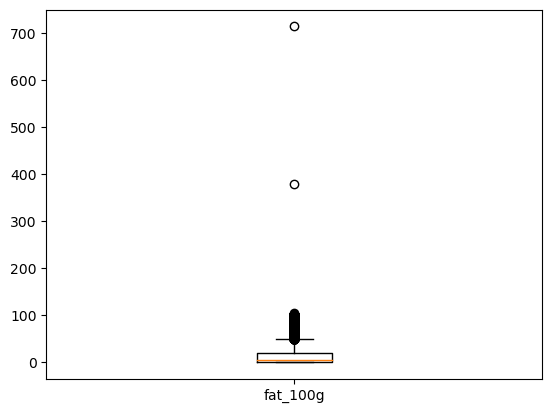

In [19]:
print("Avec valeurs abbérantes")
plt.boxplot(fat_100g, labels=["fat_100g"])
plt.show()

Sans valeurs abbérantes


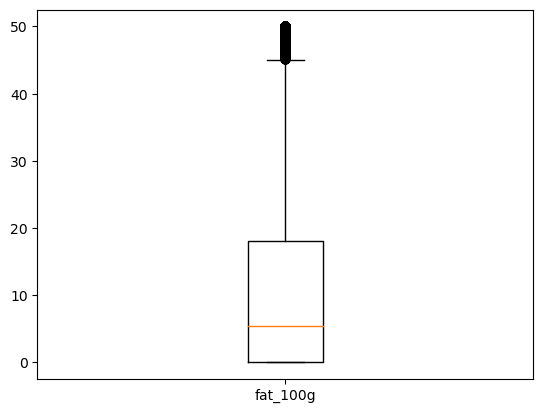

Il y a 100.0 % de valeurs définies pour fat_100g


In [20]:
# Maintenant qu'on a identifié les valeurs atypiques, on peut les traiter.
# On pourra utiliser la médiane pour traiter ces valeurs
# Réalisons une imputation par la moyenne :
print("Sans valeurs abbérantes")
fat_100g_correct = (data["fat_100g"] <= fort) & (data["fat_100g"] >= 0)

data.loc[~fat_100g_correct, "fat_100g"] = round(fat_100g.median(), 2)
fat_100g = data["fat_100g"]
plt.boxplot(fat_100g, labels=["fat_100g"])
plt.show()

t, fat_100g = defined_percentage(data, "fat_100g")
print(f"Il y a {t} % de valeurs définies pour fat_100g")

#### Gras saturé

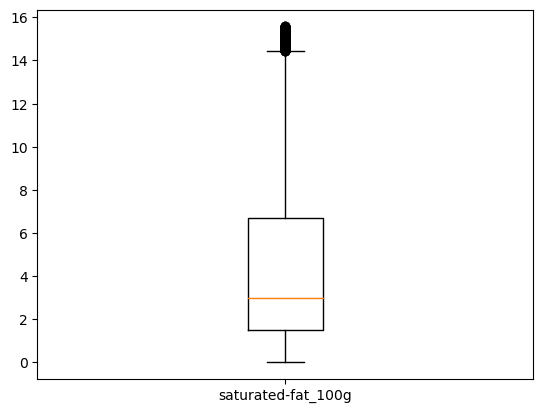

In [29]:
# Pareil pour le gras saturé qui est proche du gras, on peut utiliser la médiane pour remplacer les valeurs abbérantes
quartiles = data["saturated-fat_100g"].quantile([0.25, 0.75])
ecart = quartiles[0.75] - quartiles[0.25]
data.loc[data["saturated-fat_100g"] > (quartiles[0.75] + 1.5 * ecart), "saturated-fat_100g"] = data["saturated-fat_100g"].median()
plt.boxplot(data["saturated-fat_100g"], labels=["saturated-fat_100g"])
plt.show()

#### Sucre

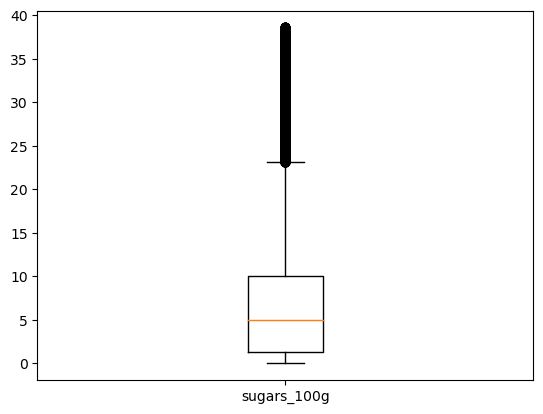

In [28]:
quartiles = data["sugars_100g"].quantile([0.25, 0.75])
ecart = quartiles[0.75] - quartiles[0.25]
data = data[data["sugars_100g"] >= 0]
data.loc[data["sugars_100g"] > (quartiles[0.75] + 1.5 * ecart), "sugars_100g"] = data["sugars_100g"].median()
plt.boxplot(data["sugars_100g"], labels=["sugars_100g"])
plt.show()

#### Energie

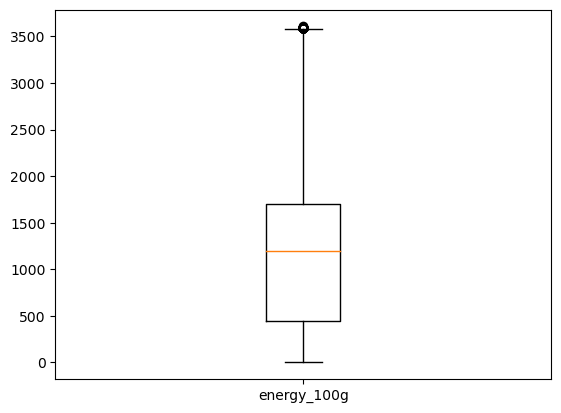

In [23]:
quartiles = data["energy_100g"].quantile([0.25, 0.75])
ecart = quartiles[0.75] - quartiles[0.25]
data.loc[data["energy_100g"] > (quartiles[0.75] + 1.5 * ecart), "energy_100g"] = data["energy_100g"].median()
plt.boxplot(data["energy_100g"], labels=["energy_100g"])
plt.show()

In [24]:
# On reset l'index des lignes avant d'utiliser dans l'analyse
data.reset_index(drop=True, inplace=True)

# Suite

Pour la suite du projet on peut corriger les valeurs aboutissant au nutri-score. Ainsi on ferai un indicateur "fait maison" à utiliser dans l'analyse pour indiquer les voyageurs suivant le nutri-score universelle et suivant d'autres indicateurs

Aller voir le fichier `analyse.ipynb` pour la partie d'analyse.